**ICOLUQANT**

Final Project

Group Leader: Noreen Leonico
Members: Tricia Zantua
         Brixter Luquing

ITE ELECTIVE 4

Course Adviser: Dr. Rodolfo Raga

The code below is establishing an NLP pipeline about text classification using pre-trained Transformer models on Hugging Face libraries and PyTorch. It has essential import statements, tokenization of text with AutoTokenizer, and initializes a pre-trained model for sequence classification with AutoModelForSequenceClassification. This is trained with the AdamW optimizer and a learning rate scheduler.

Text data is cleaned and preprocessed with NLTK's stopwords and regular expressions for enhanced model performance. A custom Dataset class in PyTorch supports efficient data handling and batching. Performance is assessed by accuracy, precision, recall, and F1 score from sklearn.metrics, providing strong evaluation of the model's predictions.

This design makes use of transfer learning, best practices in optimization, and thorough preprocessing to build an effective, scalable text classification system.

In [48]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The preprocess_text function is essential in the NLP pipeline. It prepares raw text for tokenization and model input. It performs three basic tasks: lowercasing to standardize the case of the text, removal of special characters to reduce noise, and finally, the removal of stopwords to focus on meaningful content. Ensuring cleaner and more consistent input for the tokenizer, this aligns with the expectations of pre-trained models like BERT. Integrating this preprocessing step into the pipeline enhances model performance due to reduced complexity and improved focus on relevant features and delivers improved classification.

In [49]:
# Preprocessing Function
def preprocess_text(text):
    """
    Preprocess text by:
    - Lowercasing
    - Removing special characters
    - Removing stopwords
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text


The code handles loading a dataset in either CSV or Excel format, ensuring flexibility and managing encoding issues. It then fills missing values in the sentiment columns with empty strings to maintain consistency. The core task is mapping the text to sentiment labels (positive, neutral, negative) and applying the preprocess_text function to clean the text. After processing, the data is shuffled to avoid bias during training. The class distribution is analyzed to check for balance, which helps in making adjustments for model training. Finally, the processed data is ready for tokenization and input into the model, completing the preparation phase of the NLP pipeline.

In [51]:
# Load Dataset
file_path = '/content/HyflexSHS2022-2023Labeled.csv'  # Update this path

# Check file extension and load appropriately
if file_path.endswith('.csv'):
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        print("UTF-8 encoding failed. Retrying with 'latin1' encoding.")
        df = pd.read_csv(file_path, encoding='latin1')
elif file_path.endswith('.xlsx'):
    df = pd.read_excel(file_path, engine='openpyxl')
else:
    raise ValueError("Unsupported file format. Please provide a CSV or Excel file.")

# Fill missing values with empty strings
df.fillna({"Positive": "", "Neutral": "", "Negative": ""}, inplace=True)

# Map rows into labels
data = []
for _, row in df.iterrows():
    if pd.notna(row["Positive"]) and row["Positive"].strip():
        processed_text = preprocess_text(row["Positive"])
        data.append({"text": processed_text, "label": 1})  # Positive

    if pd.notna(row["Neutral"]) and row["Neutral"].strip():
        processed_text = preprocess_text(row["Neutral"])
        data.append({"text": processed_text, "label": 2})  # Neutral

    if pd.notna(row["Negative"]) and row["Negative"].strip():
        processed_text = preprocess_text(row["Negative"])
        data.append({"text": processed_text, "label": 0})  # Negative

# Create DataFrame and shuffle
processed_df = pd.DataFrame(data)
processed_df = processed_df.sample(frac=1).reset_index(drop=True)

# Display first 5 lines of processed text data
print("\nFirst 5 processed text samples:")
print(processed_df['text'].head())

# Display class distribution
class_counts = Counter([d['label'] for d in data])
print("\nClass Distribution:")
for label, count in class_counts.items():
    sentiment = {0: "Negative", 1: "Positive", 2: "Neutral"}[label]
    print(f"{sentiment}: {count}")


UTF-8 encoding failed. Retrying with 'latin1' encoding.

First 5 processed text samples:
0                               interact online onsite
1                               study modules anywhere
2    equipment camera tv monitors microphones hyfle...
3                                           convenient
4                        teachers really excellent job
Name: text, dtype: object

Class Distribution:
Positive: 533
Neutral: 210
Negative: 190


The SentimentDataset class is a class developed for converting the preprocessed text data into a usable format by the PyTorch model for training. It includes text and labels, further tokenizes the text through a pre-trained tokenizer, and puts the data into a tensor form with the necessary parts like token IDs and attention masks. This class connects to the above code by handling the last step of preparing data for the model after it is cleaned and labeled to make it load efficiently for either training or evaluation.

In [52]:
# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['label']
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


This following piece of code defines pretraining of a pretrained model, tokenizer, splitting off datasets for training, validations and tests, and it readies the data sets before model training by populating with DataLoader objects: Here the model is being chosen as "distilbert-base-uncased"-the smaller, much quicker adaptation of BERT-and loads tokenization as well using AutoTokenizer. The dataset is divided into three sets: training, validation, and test, with 80% for training, 10% for validation, and 10% for testing. Custom dataset instances are created for each dataset by passing the corresponding data and tokenizer. DataLoader objects are created for each dataset for efficient data loading during training. Finally, the raw text will be tokenized so that the model can process it and then split into training, validation, and test sets. This connects with the earlier steps, where it was labeled, cleaned, and preprocessed.

In [53]:
# Initialize tokenizer and model from the specified pre-trained model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Split Dataset
train_size = int(0.8 * len(processed_df))
val_size = int(0.1 * len(processed_df))
test_size = len(processed_df) - train_size - val_size

train_data = processed_df[:train_size]
val_data = processed_df[train_size:train_size + val_size]
test_data = processed_df[train_size + val_size:]

train_dataset = SentimentDataset(train_data, tokenizer)
val_dataset = SentimentDataset(val_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This code defines two functions in training a sentiment analysis model: train, responsible for the entire training loop, that incorporates the model's performance on the validation set and early stopping to save the best model, and evaluate, which computes metrics such as loss, accuracy, precision, recall, and F1-score on the provided dataset.

The train function trains the model for a given number of epochs by iterating through the training data with the train_loader. It takes the input data and gives back logits, which are essentially the model's predictions. Loss calculation is performed through the criterion, and then the optimizer updates the weights of the model. This model is evaluated against the validation set, which is a val_loader, with the evaluate function. If validation loss goes down, the model gets saved, and the early stopping is activated in case of overfitting.

The evaluation function evaluates the model on a given dataset to compute performance metrics. No gradient is used to ensure memory and computation saving. Model prediction is computed with finding the index of the highest logit value. The average loss for the entire dataset is returned and the output of the metrics is printed to see how well the model has performed.

In [54]:
# Training Function
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        scheduler.step()

        val_loss = evaluate(model, val_loader, device, criterion, return_loss=True)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved to 'best_model.pth'")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Evaluation Function
def evaluate(model, data_loader, device, criterion=None, return_loss=False):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            if criterion:
                loss = criterion(logits, labels)
                total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

    if return_loss:
        return total_loss / len(data_loader)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


This code depicts the final training and testing phase of a sentiment analysis model where it combines with the former setup of the training and evaluation pipeline. The optimizer and scheduler have incorporated AdamW as the optimizer. A linear learning rate scheduler and a loss function using CrossEntropyLoss are implemented. The setup related to the device has evaluated whether there is a GPU and, if so, moved the model to it.

It is trained on the training dataset and validated on the validation dataset. Optimizer, scheduler, loss function, and device are passed as arguments to the function. This function trains the model for 10 epochs.

The model is tested by the evaluate function, which computes metrics such as accuracy, precision, recall, and F1-score on the test data. If the model file 'best_model.pth' does not exist, it prints an error message and asks the user to train the model first.

The code integrates with previous steps, integrating with the dataset and model, tokenizer, and model. The optimizer, loss function, and scheduler are crucial in the training pipeline, controlling how the model learns and adjusts its learning rate. Finally, the model is saved and loaded for testing, following the previous evaluation process.

In [55]:
# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)
total_steps = len(train_loader) * 10  # 10 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device)

# Test the model
print("\nTesting Results:")
if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('best_model.pth'))
    evaluate(model, test_loader, device)
else:
    print("Error: 'best_model.pth' not found. Train the model first.")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 | Train Loss: 0.8244 | Val Loss: 0.5619
Model saved to 'best_model.pth'
Epoch 2/10 | Train Loss: 0.4761 | Val Loss: 0.5030
Model saved to 'best_model.pth'
Epoch 3/10 | Train Loss: 0.2689 | Val Loss: 0.5381
Epoch 4/10 | Train Loss: 0.1638 | Val Loss: 0.5033
Early stopping triggered.

Testing Results:


<ipython-input-55-d82c11e9bb0f>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.7447
Precision: 0.6930, Recall: 0.7237, F1-Score: 0.6866


This code imports libraries in data visualization, model evaluations, and deep learning with Matplotlib and Seaborn for plotting confusion matrices and the training curves, using scikit-learn's functions for confusion_matrix and classification report, and using PyTorch and DataLoader for effective working with datasets.

Prediction Accuracy: 74.47%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.61      0.68        23
    Positive       0.88      0.79      0.84        58
     Neutral       0.42      0.77      0.54        13

    accuracy                           0.74        94
   macro avg       0.69      0.72      0.69        94
weighted avg       0.79      0.74      0.76        94



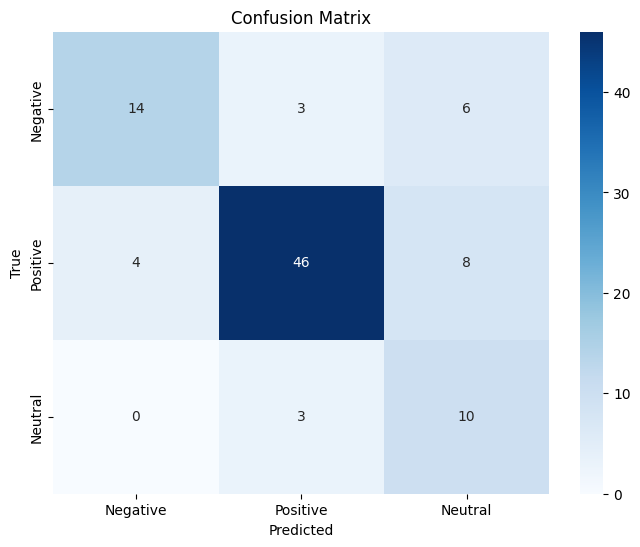

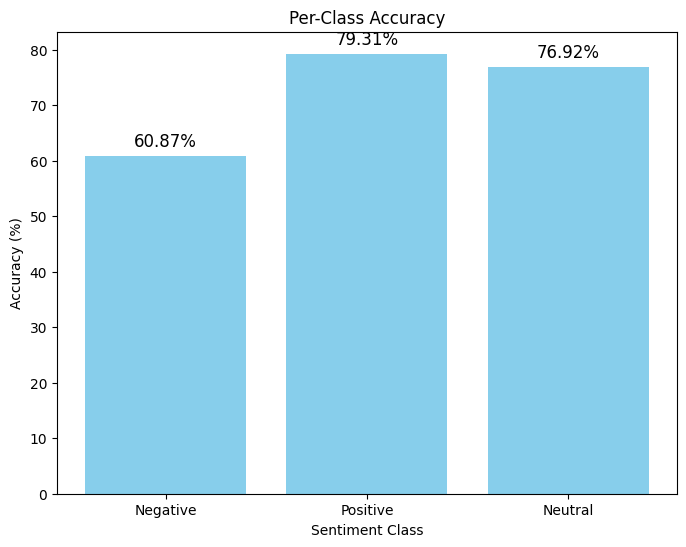

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import DataLoader

def predict_with_graph(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_predictions += (preds == labels).sum().item()
            total_predictions += len(labels)

    accuracy = correct_predictions / total_predictions * 100
    print(f"Prediction Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive", "Neutral"]))

    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive", "Neutral"],
                yticklabels=["Negative", "Positive", "Neutral"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Per-Class Accuracy
    class_counts = [sum([1 for label in all_labels if label == i]) for i in range(3)]
    class_correct = [sum([(pred == label) for pred, label in zip(all_preds, all_labels) if label == i]) for i in range(3)]
    class_accuracy = [correct / total * 100 for correct, total in zip(class_correct, class_counts)]

    # Plot Per-Class Accuracy
    plt.figure(figsize=(8, 6))
    bars = plt.bar(["Negative", "Positive", "Neutral"], class_accuracy, color="skyblue")
    plt.title("Per-Class Accuracy")
    plt.xlabel("Sentiment Class")
    plt.ylabel("Accuracy (%)")

    for bar, accuracy in zip(bars, class_accuracy):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{accuracy:.2f}%",
                 ha='center', va='bottom', fontsize=12)

    plt.show()

# Example of creating a DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Assuming model and device are already defined
predict_with_graph(model, test_loader, device)


The code snippet demonstrates the use of the torch.nn.functional module, which provides functional operations such as activation and loss functions. The analyze_feedback function is used to preprocess input text, tokenize it into a model-friendly format, and pass the tokenized text through the model for sentiment prediction. The tokenizer converts the preprocessed text into a suitable format, ensuring all inputs have the same size. The tokenizer moves the tokens to the correct device for efficient computation.

The model is then evaluated using the torch.no_grad() function, which disables operations like dropout during training but not during inference. The outputs are then passed through the model to get predictions, with logits representing the raw prediction scores for each sentiment class. The softmax function is applied to the logits to convert them into probabilities, ensuring that the probabilities for each class sum up to 1.

The output results are printed, including the original feedback, preprocessed version, predicted sentiment label, and confidence scores for each sentiment class. The program also includes an example user input loop, where the analyze_feedback function is called to process and predict the sentiment for each input.

In [77]:
import torch.nn.functional as F

def analyze_feedback(model, feedback, tokenizer, device):
    """
    Analyze the sentiment of a single feedback input.
    - Tokenizes and processes feedback text.
    - Predicts sentiment and returns confidence percentages.
    """
    # Preprocess feedback
    feedback_preprocessed = preprocess_text(feedback)

    # Tokenize feedback
    tokens = tokenizer(
        feedback_preprocessed,
        padding="max_length",
        truncation=True,
        max_length=256,  # Increased max length
        return_tensors="pt"
    )

    # Move tokens to device
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        # The model directly returns logits, not a dictionary
        outputs = model(input_ids, attention_mask=attention_mask)
        # Get the logits from the output object
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1).squeeze(0)

    # Get sentiment predictions and confidence scores
    class_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_label = torch.argmax(probabilities).item()
    confidence_scores = probabilities.cpu().numpy() * 100

    # Output the results
    print(f"\nOriginal Feedback: {feedback}")
    print(f"Preprocessed Feedback: {feedback_preprocessed}")
    print(f"Predicted Sentiment: {class_mapping[predicted_label]}")
    print(f"Confidence Scores:")
    for i, sentiment in class_mapping.items():
        print(f"  {sentiment}: {confidence_scores[i]:.2f}%")

# Example Usage
while True:
    feedback_input = input("\nEnter your feedback (or type 'quit' to end): ")
    if feedback_input.lower() == 'quit':
        break  # Exit the loop if the user types 'quit'

    analyze_feedback(model, feedback_input, tokenizer, device)

print("Program ended.")


Enter your feedback (or type 'quit' to end): HyFlex learning has transformed my education experience by offering flexibility and personalized learning opportunities.

Original Feedback: HyFlex learning has transformed my education experience by offering flexibility and personalized learning opportunities.
Preprocessed Feedback: hyflex learning transformed education experience offering flexibility personalized learning opportunities
Predicted Sentiment: Neutral
Confidence Scores:
  Negative: 12.31%
  Neutral: 54.52%
  Positive: 33.17%

Enter your feedback (or type 'quit' to end): should have stable internet

Original Feedback: should have stable internet
Preprocessed Feedback: stable internet
Predicted Sentiment: Negative
Confidence Scores:
  Negative: 94.42%
  Neutral: 1.36%
  Positive: 4.21%

Enter your feedback (or type 'quit' to end): I love hyflex learning it very convinient

Original Feedback: I love hyflex learning it very convinient
Preprocessed Feedback: love hyflex learning c